# DeepNN for Sink Particles
> Created Oct. 2024 <br>
> Nikhil Bisht<br>

In [1]:
# standard system modules
import os, sys

# standard module for tabular data
import pandas as pd

# standard module for array manipulation
import numpy as np

# standard statistical module
import scipy.stats as st

# standard module for high-quality plots
import matplotlib as mp
import matplotlib.pyplot as plt
mp.rcParams.update(mp.rcParamsDefault)
%matplotlib inline

# standard research-level machine learning toolkit from Meta (FKA: FaceBook)
import torch
import torch.nn as nn


# set a seed to ensure reproducibility
seed = 128
rnd  = np.random.RandomState(seed)

## Constants

In [2]:
DATAFILE  = '/data/cb1/nbisht/anvil_scratch/projects/128/B2/datasets/final_88/nb101_ML_dataset.csv'
MODELFILE = 'nnmodel.dict'

#In percentage
NTRAIN_percentage =  0.8
NVALID_percentage =  0.05
NTEST_percentage  =  0.15

TARGET = ['O_Clump_X', 'O_Clump_Y',	'O_Clump_Z', 'O_Clump_Vx', 'O_Clump_Vy', 'O_Clump_Vz', 'O_Clump_density','O_t_end']
FEATURES = ['X', 'Y', 'Z', 'Density', 'Vx', 'Vy', 'Vz', 't_hard']

n_input = len(FEATURES)
n_output = len(TARGET)

#DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE = torch.device('cpu')

print(f'Available device: {str(DEVICE):4s}')
print(n_input, n_output)

Available device: cpu 
8 8


## Load data

In [3]:
df = pd.read_csv(DATAFILE)
d_nonclump = df[df.Clump_id <0]
d_clump = df[df.Clump_id >0]
print(len(df))
print("amount of nonclump data:",float(d_nonclump.count()['Clump_id']/df.count()['Clump_id']))
df.head()

2097152
amount of nonclump data: 0.9898881912231445


,Unnamed: 0,Clump_id,Particle_id,X,Y,Z,Density,Vx,Vy,Vz,t_hard,O_Clump_X,O_Clump_Y,O_Clump_Z,O_Clump_Vx,O_Clump_Vy,O_Clump_Vz,O_Clump_density,O_t_end
0,0,2,86076.0,0.339811,0.134624,0.137327,765.475687,-5.696933,5.085002,-2.849526,0.620028,0.328734,0.135963,0.128912,-6.392839,-6.392839,-2.518608,2706.596838,0.66003
1,1,2,86077.0,0.339542,0.134248,0.136532,936.301305,-6.040428,4.622971,-2.583300,0.620028,0.328734,0.135963,0.128912,-6.392839,-6.392839,-2.518608,2706.596838,0.66003
2,2,2,90172.0,0.338404,0.126431,0.135963,462.601489,-5.731839,4.998208,-2.695267,0.620028,0.328734,0.135963,0.128912,-6.392839,-6.392839,-2.518608,2706.596838,0.66003
3,3,2,90173.0,0.340331,0.124604,0.134357,693.797771,-4.973129,5.235317,-2.662311,0.620028,0.328734,0.135963,0.128912,-6.392839,-6.392839,-2.518608,2706.596838,0.66003
4,4,2,90174.0,0.340503,0.126074,0.134297,1088.844742,-5.258341,4.987108,-2.725896,0.620028,0.328734,0.135963,0.128912,-6.392839,-6.392839,-2.518608,2706.596838,0.66003


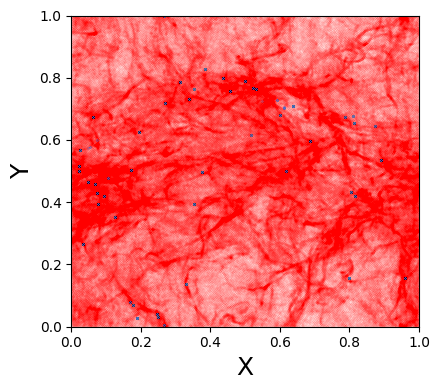

In [15]:
def plot_data():
    
    fig = plt.figure(figsize=(4.5, 4))
    
    ax  = fig.add_subplot(111)
    
    
    ax.set_xlim(0, 1)
    ax.set_xlabel('X', fontsize=18)
    
    ax.set_ylim(0, 1)
    ax.set_ylabel('Y', fontsize=18)
    
    d1 = d_nonclump
    xp, yp = d1.O_Clump_X, d1.O_Clump_Y
    ax.scatter(xp, yp, s=1e-4, color='red')
    
    d2 = d_clump
    xp, yp = d2.O_Clump_X, d2.O_Clump_Y
    ax.scatter(xp, yp, s=1e-3, color='royalblue');
    
    fig.tight_layout()
    
    plt.show()

plot_data()

In [13]:
NTRAIN_nonclump = int(NTRAIN_percentage*d_nonclump.count()['Clump_id'])
NTRAIN_clump = int(NTRAIN_percentage*d_clump.count()['Clump_id'])

NTEST_nonclump = int(NTEST_percentage*d_nonclump.count()['Clump_id'])
NTEST_clump = int(NTEST_percentage*d_clump.count()['Clump_id'])

NVALID_nonclump = int(d_nonclump.count()['Clump_id']) - NTRAIN_nonclump - NTEST_nonclump
NVALID_clump = int(d_clump.count()['Clump_id']) - NTRAIN_clump - NTEST_clump


## Split data and Convert to tensors

In [16]:
train_data_clump  = d_clump[:NTRAIN_clump]
train_data_nonclump  = d_nonclump[:NTRAIN_nonclump]

valid_data_clump  = d_clump[NTRAIN_clump:NTRAIN_clump+NVALID_clump]
valid_data_nonclump  = d_nonclump[NTRAIN_nonclump:NTRAIN_nonclump+NVALID_nonclump]

test_data_clump = d_clump[NTRAIN_clump+NVALID_clump:]
test_data_nonclump = d_nonclump[NTRAIN_nonclump+NVALID_nonclump:]

def dataframe2tensor(df, target, source):
    # change from pandas dataframe to PyTorch tensors
    # and load data to device.
    x = torch.tensor(df[source].to_numpy()).float().to(DEVICE)
    y = torch.tensor(df[target].to_numpy()).float().to(DEVICE)
    return x, y

#JUST USING CLUMPED DATA
train_x, train_y = dataframe2tensor(train_data_clump, TARGET, FEATURES)
valid_x, valid_y = dataframe2tensor(valid_data_clump, TARGET, FEATURES)
test_x,  test_y  = dataframe2tensor(test_data_clump,  TARGET, FEATURES)

train_x.shape, train_y.shape

(torch.Size([16964, 8]), torch.Size([16964, 8]))

## Some ML Utilities

In [18]:
def get_batch(x, y, batch_size, ii):
    # cycle through batches of training data sequentially
    K = int(len(x) / batch_size + 0.5) # number of batches / epoch
    jj = ii % K
    start = jj * batch_size
    end = start + batch_size - 1
    if end > len(x)-1:
        end = len(x)-1
    return x[start: end+1], y[start: end+1], jj

def get_random_batch(x, y, batch_size):
    # selects at random "batch_size" integers from 
    # the range [0, batch_size-1] corresponding to the
    # row indices of the training data
    rows = torch.randint(0, len(x)-1, size=(batch_size,))
    return x[rows], y[rows]
        
def validate(model, avloss, x, y):
    # set to evaluation mode so that any training 
    # specific operations are disabled.
    model.eval()
    with torch.no_grad(): # no need to compute gradients wrt. x and y
        # reshape to ensure that f and y are of the same shape!
        f = model(x).reshape(y.shape)
    return avloss(f, y)

def number_of_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def plot_loss_curve(losses,hyperparam):
    
    xx, yy_t, yy_v = losses
    
    # create an empty figure
    fig = plt.figure(figsize=(5, 3.8))
    fig.tight_layout()
    
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows,ncols,index)
    
    ax.plot(xx, yy_t, color='red',  lw=1, label='training loss')
    ax.plot(xx, yy_v, color='blue', lw=1, label='validation loss')
    ax.legend()
    
    ax.set_xlabel('iterations')
    ax.set_ylabel('average loss')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(True, which="both", linestyle='-')

    name_str = ''
    for hi in range(len(hyperparam)):
        name_str += '_H'+str(hi+1)+'_'+str(hyperparam[hi])
    plt.savefig("../../plots_to_sort/ANN_Split_Losses/4_Layer_model"+name_str+".png")
    plt.close()

## Train model

In [21]:
#%%writefile nnmodel.py
def define_and_train_model(hyperp=[2], n_iterations  = 12000, n_epochs = 1):
    try:
        del model
    except:
        print("No model to delete")
    import torch.nn as nn
    n_input = 8
    n_output = 8
    H = hyperp[0]
    model = nn.Sequential(nn.Linear(n_input, H), nn.ReLU(), nn.BatchNorm1d(H), nn.Dropout(0.2),
                        nn.Linear(H, 2*H), nn.ReLU(), nn.BatchNorm1d(2*H), nn.Dropout(0.3),
                        nn.Linear(2*H, H), nn.ReLU(), nn.BatchNorm1d(H),
                        nn.Linear(H, int(H/2)), nn.ReLU(),
                        nn.Linear(int(H/2), n_output))
    #from nnmodel import model

    learning_rate = 1.e-4
    optimizer     = torch.optim.Adam(model.parameters(), lr=learning_rate) 

    n_batch  = 32
    n_step   = 10
    n_valid  = len(valid_x)
    train_x2 = train_x[:n_valid]
    train_y2 = train_y[:n_valid]

    emprisk  = nn.HuberLoss(delta=0.0005)
    #print(number_of_parameters(model),model)
    # Train model
    USE_SEQUENTIAL_BATCHES = True

    epoch = 0

    X = []
    T = []
    V = []

    min_avloss = float('inf')

    while epoch<n_epochs:
        for ii in range(n_iterations):

            # clear previous gradients
            
            optimizer.zero_grad()
            
            # set mode to training so that training specific 
            # operations such as dropout are enabled.
            
            model.train()

            # get a batch of data 

            if USE_SEQUENTIAL_BATCHES:
                x, y, jj = get_batch(train_x, train_y, n_batch, ii)
                if jj == 0:
                    epoch += 1
            else:
                x, y = get_random_batch(train_x, train_y, n_batch)  
            
            f = model(x).reshape(y.shape)

            R = emprisk(f, y)
            
            R.backward()  # compute gradients of with respect to NN parameters

            optimizer.step()    # advance one step in the space of NN parameters

            if ii % n_step == 0:
                
                t_loss = validate(model, emprisk, train_x2, train_y2).detach()
                v_loss = validate(model, emprisk, valid_x,  valid_y).detach()

                print(f'\r|{epoch:9d}|{ii:9d}|{t_loss:9.3e}|{v_loss:9.3e}|', end='')

                X.append(ii)
                T.append(float(t_loss))
                V.append(float(v_loss))

                if v_loss < 0.995 * min_avloss:
                    min_avloss = v_loss
                    torch.save(model.state_dict(), MODELFILE)
                
        print()

    plot_loss_curve([X, T, V], H)
    return model

No model to delete
|       23|    11990|9.063e+00|2.323e+00|


TypeError: object of type 'int' has no len()

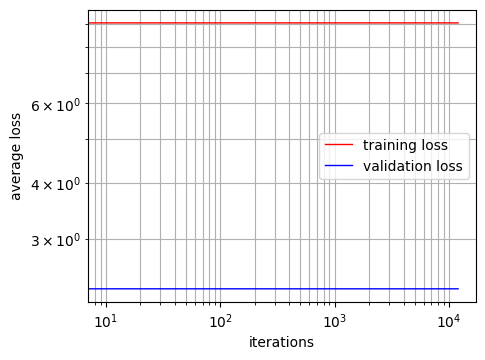

In [22]:
import sklearn.metrics as skm
best_model_arr = []
#hyperparam_value H = 4 for 4 layer
#hyperparam_value H = 2 for 3 layer
#hyperparam_value H = 8 for 2 layer

for hyperparam_value in range(2,8,2):
    model = define_and_train_model([hyperparam_value])
    # standard measures of model performance
    # set to evaluation mode so that any training 
    # specific operations are disabled.
    model.eval()
    with torch.no_grad(): # no need to compute gradients wrt. x and y
        # reshape to ensure that f and y are of the same shape!
        f = model(test_x).reshape(test_y.shape)
    v_loss = emprisk(f, test_y).detach()
    rmse = skm.root_mean_squared_error(test_y,f.detach())
    r2 = skm.r2_score(test_y,f.detach())
    best_model_arr.append([hyperparam_value,v_loss,rmse,r2])
best_model_arr